In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [2]:
# ============================
# 配置参数
# ============================

imageA_path = "../datasets/yongzhou/DSC03201.JPG"  # 图像A的路径
imageB_path = "../datasets/yongzhou/DSC03203.JPG"  # 图像B的路径
imageC_path = "../datasets/yongzhou/DSC03205.JPG"  # 图像C的路径

# KNN 匹配参数
distance_ratio = 0.5  # KNN匹配的距离比率
ransac_threshold = 10   # RANSAC阈值
min_matches_required = 20  # 计算单应性矩阵所需的最小匹配点数量

# 图像增强参数
clahe_clip_limit = 2.0  # CLAHE对比度限制
clahe_tile_grid_size = (5, 5)  # CLAHE的网格大小

In [3]:
# ============================
# 函数定义
# ============================

# 1. 使用matplotlib显示图片
def show_image(image, title="Image"):
    """
    使用 Matplotlib 显示图像
    参数:
    - image: 待显示的图像，必须是 BGR 格式
    - title: 图像的标题，默认为 'Image'
    """
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # 转换为RGB格式
    plt.title(title)  # 设置图像标题
    plt.axis('off')  # 关闭坐标轴
    plt.show()  # 显示图像


In [4]:
# 2. 定义特征点检测和描述函数
def detectAndDescribe(image):
    """
    使用 SIFT 进行特征点的检测和描述
    参数:
    - image: 输入的彩色图像 (BGR)
    
    返回:
    - kps: 检测到的关键点列表
    - kps_float: 浮点格式的关键点坐标
    - des: 每个关键点对应的描述符
    """
    # 图像预处理：CLAHE增强
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # 转换为灰度图
    
    # 创建CLAHE对象
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)  # 应用CLAHE
    
    # 边缘增强
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])  # 锐化滤波器
    sharpened = cv2.filter2D(enhanced, -1, kernel)  # 应用锐化滤波器
    
    descriptor = cv2.SIFT_create(nOctaveLayers=5)  # 创建SIFT对象，并增大nOctaveLayers
    (kps, des) = descriptor.detectAndCompute(sharpened, None)  # 检测关键点并计算描述符
    kps_float = np.float32([kp.pt for kp in kps])  # 提取关键点的坐标，转换为浮点数
    return (kps, kps_float, des)

In [5]:
# 3. 特征点匹配函数
def match_keypoints(desA, desB):
    """
    使用 KNN 匹配两个图像的特征点，并筛选出优质的匹配点
    参数:
    - desA: 图像A的描述符
    - desB: 图像B的描述符
    
    返回:
    - good_matches: 筛选出的优质匹配
    - matches: 匹配的特征点索引
    """
    matcher = cv2.BFMatcher()  # 创建BF匹配器
    rawMatches = matcher.knnMatch(desB, desA, 2)  # 使用 KNN 进行匹配
    good_matches = []  # 用于存储优质的匹配点
    matches = []  # 用于存储匹配点的索引
    for m in rawMatches:
        if len(m) == 2 and m[0].distance < distance_ratio * m[1].distance:  # 过滤匹配点
            good_matches.append(m)  # 保存有效匹配点
            matches.append((m[0].trainIdx, m[0].queryIdx))  # 保存索引
    return good_matches, matches

In [6]:
# 4. 绘制匹配结果函数
def draw_matches(imageA, kpsA, imageB, kpsB, good_matches):
    """
    绘制两个图像之间的特征点匹配结果
    参数:
    - imageA: 图像A
    - kpsA: 图像A的关键点
    - imageB: 图像B
    - kpsB: 图像B的关键点
    - good_matches: 筛选出的优质匹配点
    
    返回:
    - vis: 显示的图像（包含匹配的关键点）
    """
    vis = cv2.drawMatchesKnn(imageB, kpsB, imageA, kpsA, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return vis

In [7]:
def stitch_images(center_image, align_image, center_kps_float, align_kps_float, matches, center_position=None):
    """
    使用给定的特征点和匹配关系，将 align_image 对齐到 center_image。
    
    参数:
    - center_image: 中心参考图像（例如 B 图像）
    - align_image: 要对齐到中心图像的图像（例如 A 或 C 图像）
    - center_kps_float: 中心图像的关键点坐标
    - align_kps_float: 要对齐图像的关键点坐标
    - matches: 关键点的匹配索引
    - center_position: 用于定位中心图像的画布位置 (x, y)

    返回:
    - 拼接后的图像，将 align_image 对齐到 center_image 上
    """
    if len(matches) > min_matches_required:
        # 获取匹配的坐标点
        pts_center = np.float32([center_kps_float[i] for (i, _) in matches])
        pts_align = np.float32([align_kps_float[i] for (_, i) in matches])

        # 计算对齐图像到中心图像的单应性矩阵
        H, _ = cv2.findHomography(pts_align, pts_center, cv2.RANSAC, ransac_threshold)

        # 计算中心图像的平移，确保它在画布中央
        height_center, width_center = center_image.shape[:2]
        height_align, width_align = align_image.shape[:2]

        # 设置中心图像在画布中的位置
        if center_position is None:
            center_position = (width_center // 2, height_center // 2)

        # 创建一个足够大的画布，能够容纳两个图像的拼接
        canvas_size = (height_center * 2, width_center * 2)
        translation_dist = (canvas_size[1] // 4, canvas_size[0] // 4)
        
        # 转换 H_translation 为浮点类型
        H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]], dtype=np.float32)

        # 先将中心图像平移到画布中心
        result = cv2.warpPerspective(center_image, H_translation, canvas_size)
        
        # 将对齐图像按单应性矩阵变换并叠加到中心图像上
        H_combined = H_translation @ H.astype(np.float32)  # 转换 H 为浮点类型
        warped_align = cv2.warpPerspective(align_image, H_combined, canvas_size)

        # 使用最大值拼接，保持图像边界过渡平滑
        result = np.maximum(result, warped_align)
        
        return result
    else:
        print(f"未找到足够的匹配点（需要至少 {min_matches_required} 个）")
        return None


In [8]:
def create_canvas(images):
    # 获取每张图像的尺寸
    heights = [img.shape[0] for img in images]
    widths = [img.shape[1] for img in images]

    # 计算总画布的尺寸
    total_width = sum(widths)
    max_height = max(heights)

    # 创建黑色画布
    canvas = np.zeros((max_height, total_width, 3), dtype=np.uint8)

    # 将图像放入画布
    x_offset = 0
    for img in images:
        canvas[0:img.shape[0], x_offset:x_offset + img.shape[1]] = img
        x_offset += img.shape[1]

    return canvas

In [9]:
# ============================
# 读取图像并检查是否成功
# ============================

imageA = cv2.imread(imageA_path)
imageB = cv2.imread(imageB_path)
imageC = cv2.imread(imageC_path)

if imageA is None:
    print(f"无法加载图像A，请检查路径或文件格式：{imageA_path}")
if imageB is None:
    print(f"无法加载图像B，请检查路径或文件格式：{imageB_path}")
if imageC is None:
    print(f"无法加载图像C，请检查路径或文件格式：{imageC_path}")


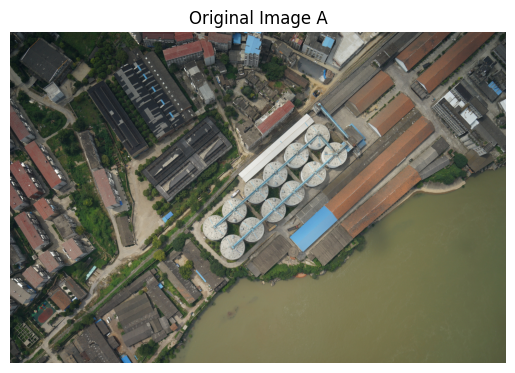

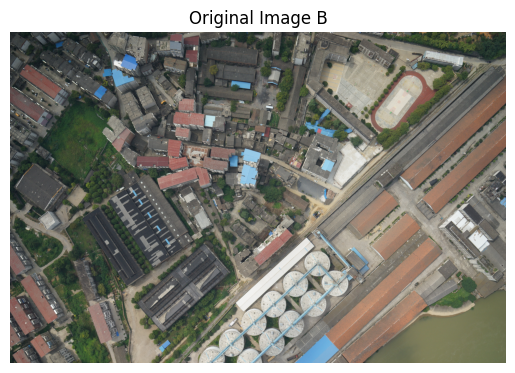

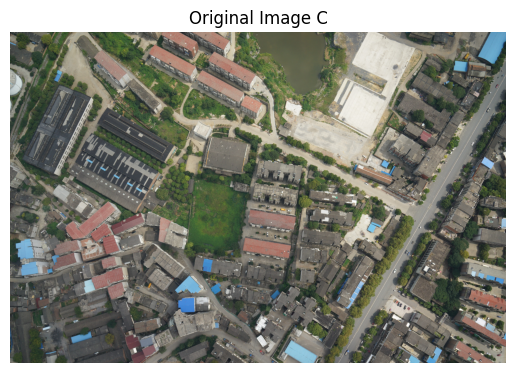

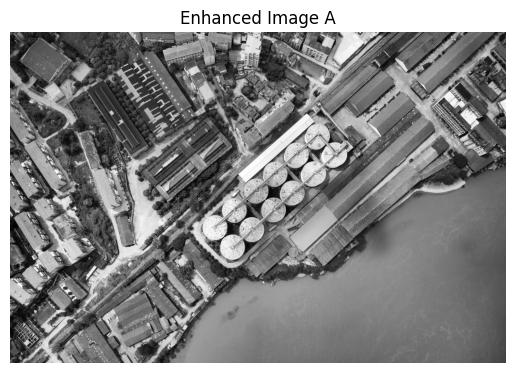

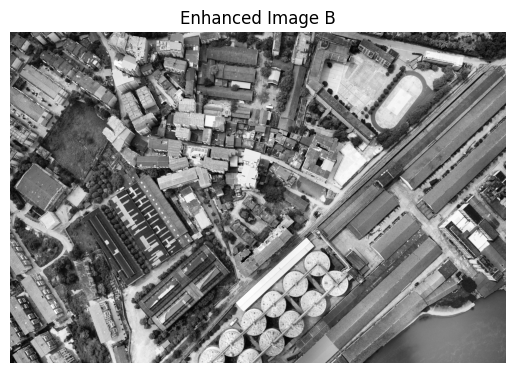

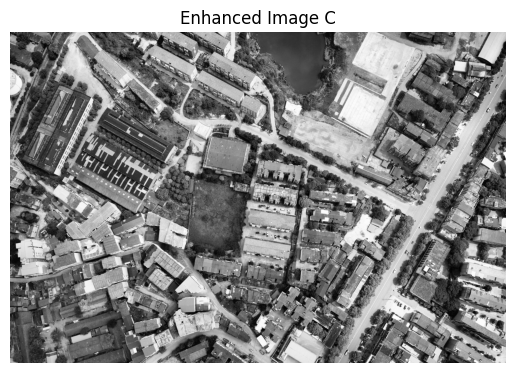

匹配到 A 和 B 462 个特征点
匹配到 B 和 C 124 个特征点


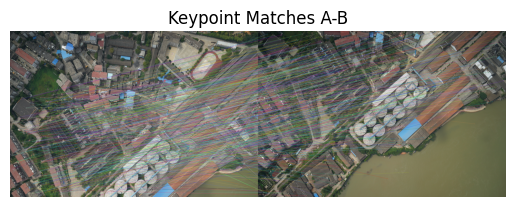

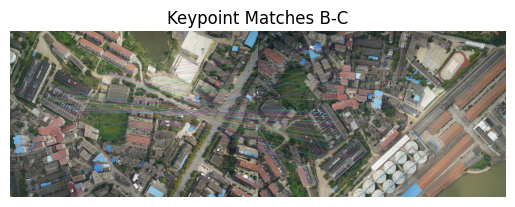

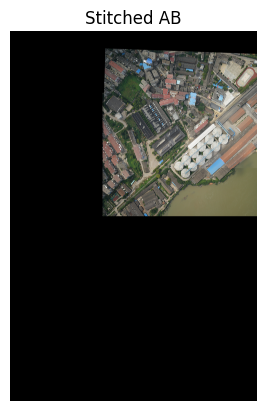

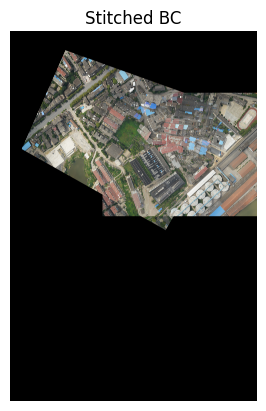

匹配到 stitchedAB 和 stitchedBC 2168 个特征点


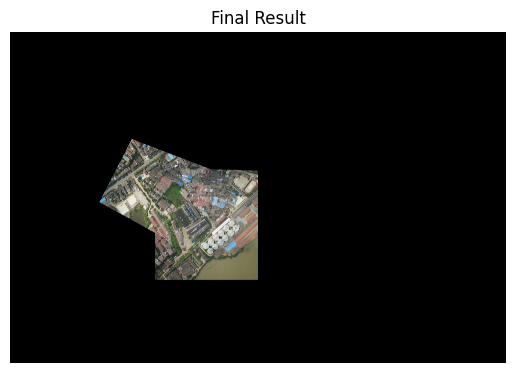

拼接结果已保存至: ./output_KNN/stitched_201_203_205.jpg


In [ ]:
# 如果成功加载，继续执行后续操作
if imageA is not None and imageB is not None and imageC is not None:
    # 显示原图像
    show_image(imageA, 'Original Image A')
    show_image(imageB, 'Original Image B')
    show_image(imageC, 'Original Image C')

    # 检测特征点和描述符
    (kpsA, kps_floatA, desA) = detectAndDescribe(imageA)
    (kpsB, kps_floatB, desB) = detectAndDescribe(imageB)
    (kpsC, kps_floatC, desC) = detectAndDescribe(imageC)

    # 显示增强后的图像
    enhancedA = cv2.createCLAHE(clipLimit=clahe_clip_limit, tileGridSize=clahe_tile_grid_size).apply(cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY))
    enhancedB = cv2.createCLAHE(clipLimit=clahe_clip_limit, tileGridSize=clahe_tile_grid_size).apply(cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY))
    enhancedC = cv2.createCLAHE(clipLimit=clahe_clip_limit, tileGridSize=clahe_tile_grid_size).apply(cv2.cvtColor(imageC, cv2.COLOR_BGR2GRAY))
    
    show_image(cv2.cvtColor(enhancedA, cv2.COLOR_GRAY2BGR), 'Enhanced Image A')
    show_image(cv2.cvtColor(enhancedB, cv2.COLOR_GRAY2BGR), 'Enhanced Image B')
    show_image(cv2.cvtColor(enhancedC, cv2.COLOR_GRAY2BGR), 'Enhanced Image C')

    # 匹配特征点
    good_matches_AB, matches_AB = match_keypoints(desA, desB)
    print(f"匹配到 A 和 B {len(good_matches_AB)} 个特征点")
    
    good_matches_BC, matches_BC = match_keypoints(desB, desC)
    print(f"匹配到 B 和 C {len(good_matches_BC)} 个特征点")

    # 绘制匹配结果
    vis_AB = draw_matches(imageA, kpsA, imageB, kpsB, good_matches_AB)
    show_image(vis_AB, 'Keypoint Matches A-B')

    vis_BC = draw_matches(imageB, kpsB, imageC, kpsC, good_matches_BC)
    show_image(vis_BC, 'Keypoint Matches B-C')

    # 1. 拼接 A 和 B（生成 stitchedAB）
    stitchedAB = stitch_images(imageA, imageB, kps_floatA, kps_floatB, matches_AB)
    show_image(stitchedAB, 'Stitched AB')  # 显示 A 和 B 的拼接结果

    # 2. 拼接 B 和 C（生成 stitchedBC）
    stitchedBC = stitch_images(imageB, imageC, kps_floatB, kps_floatC, matches_BC)
    show_image(stitchedBC, 'Stitched BC')  # 显示 B 和 C 的拼接结果

    # 最终拼接 stitchedAB 和 stitchedBC
    if stitchedAB is not None and stitchedBC is not None:
        # 检测拼接结果 stitchedAB 和 stitchedBC 的特征点
        (kps_stitchedAB, kps_float_stitchedAB, des_stitchedAB) = detectAndDescribe(stitchedAB)
        (kps_stitchedBC, kps_float_stitchedBC, des_stitchedBC) = detectAndDescribe(stitchedBC)

        # 匹配 stitchedAB 和 stitchedBC 的特征点
        good_matches_final, matches_final = match_keypoints(des_stitchedAB, des_stitchedBC)
        print(f"匹配到 stitchedAB 和 stitchedBC {len(good_matches_final)} 个特征点")

        # 3. 最终对齐 stitchedAB 和 stitchedBC，生成 final_result
        final_result = stitch_images(stitchedAB, stitchedBC, kps_float_stitchedAB, kps_float_stitchedBC, matches_final)
        
        # 显示和保存最终结果
        if final_result is not None:
            show_image(final_result, 'Final Result')  # 显示最终拼接结果

            # 保存拼接结果
            baseA = os.path.basename(imageA_path)[-7:-4]
            baseB = os.path.basename(imageB_path)[-7:-4]
            baseC = os.path.basename(imageC_path)[-7:-4]
            output_filename = f"./output_KNN/stitched_{baseA}_{baseB}_{baseC}.jpg"
            os.makedirs('./output_KNN', exist_ok=True)
            cv2.imwrite(output_filename, final_result)
            print(f"拼接结果已保存至: {output_filename}")
        else:
            print("拼接 stitchedAB 和 stitchedBC 失败，无法生成最终结果。")
    else:
        print("无法拼接 A-B 或 B-C，拼接过程失败。")
